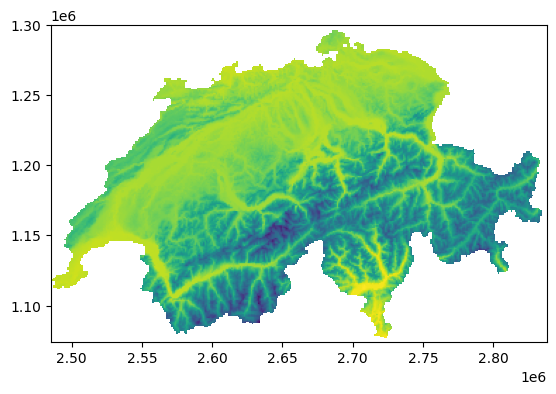

<Axes: >

In [109]:
import rasterio
from rasterio.plot import show
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

fp = r'geo_tiffs/annual_mean_temperature_switzerland.tif'
img = rasterio.open(fp)
show(img)

In [110]:
mean_temp_data_riox = rioxarray.open_rasterio('geo_tiffs/annual_mean_temperature_switzerland.tif')
mean_temp_data_riox.name = "data"
df = mean_temp_data_riox.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
mean_temp_data_gpd = gpd.GeoDataFrame(df, crs=mean_temp_data_riox.rio.crs, geometry=geometry)

mean_temp_data_gpd.shape

mean_temp_data_gpd.dropna(inplace=True)

mean_temp_data_gpd.head()

c:\Users\lcsch\anaconda3\envs\data-science\Lib\site-packages\pyproj\crs\_cf1x8.py:515: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


,y,x,band,spatial_ref,data,geometry
1611,1295500.0,2684500.0,1,0,7.2,POINT (2684500 1295500)
1612,1295500.0,2685500.0,1,0,7.3,POINT (2685500 1295500)
1613,1295500.0,2686500.0,1,0,7.3,POINT (2686500 1295500)
1614,1295500.0,2687500.0,1,0,7.5,POINT (2687500 1295500)
1615,1295500.0,2688500.0,1,0,7.7,POINT (2688500 1295500)


In [111]:
from shapely.wkt import loads

swiss_data_df = pd.read_csv('processed_data/swiss_data_all.csv')
swiss_data_df['geometry'] = swiss_data_df['geometry'].apply(loads)
swiss_data = gpd.GeoDataFrame(swiss_data_df, geometry=swiss_data_df['geometry'])
swiss_data.crs = 'EPSG:2056'

joined = gpd.sjoin(swiss_data, mean_temp_data_gpd, how="left", predicate="contains")
swiss_data['mean_annual_temp'] = joined['data']

In [112]:
# Détection des jointures spatiales qui n'ont pas pu s'effectuer
print(swiss_data['mean_annual_temp'].isna().sum())
print(len(swiss_data))

626
42444


C:\Users\lcsch\AppData\Local\Temp\ipykernel_16900\2240203043.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\lcsch\AppData\Local\Temp\ipykernel_16900\2240203043.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


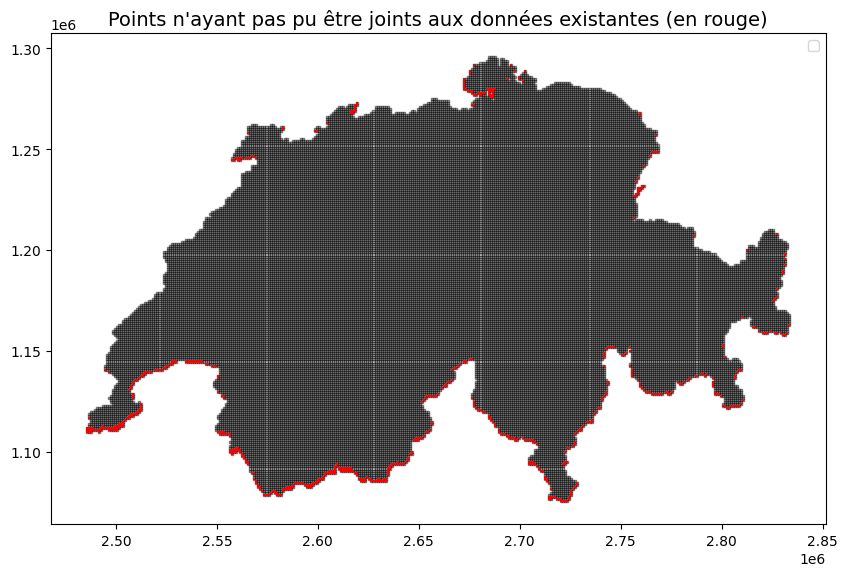

In [113]:
unmatched_points = joined[joined['index_right'].isna()]  # 'index_right' est NaN si aucun polygone ne correspond
fig, ax = plt.subplots(figsize=(10, 10))
swiss_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label="Swiss Data Polygons")
unmatched_points.plot(ax=ax, color='red', markersize=10, label="Unmatched Points")
ax.set_title("Points n'ayant pas pu être joints aux données existantes (en rouge)", fontsize=14)
ax.legend()
plt.show()

### Explication

Nous pensons que la raison pour laquelle certains points n'ont pas pu correspondre est dû au fait que les données ne proviennent pas du même endroit (Google Earth pour les données de températures VS Geoadmin pour le reste).

Il est possible que les frontières Suisse ne soient pas exactement les mêmes sur ces deux sources de données.

In [114]:
# Retirer les points manquants
count_before = len(swiss_data)
swiss_data.dropna(axis=0, subset=['mean_annual_temp'], inplace=True)
count_after = len(swiss_data)
print('Before | After :',count_before,count_after)
print(swiss_data['mean_annual_temp'].isna().sum())

Before | After : 42444 41818
0


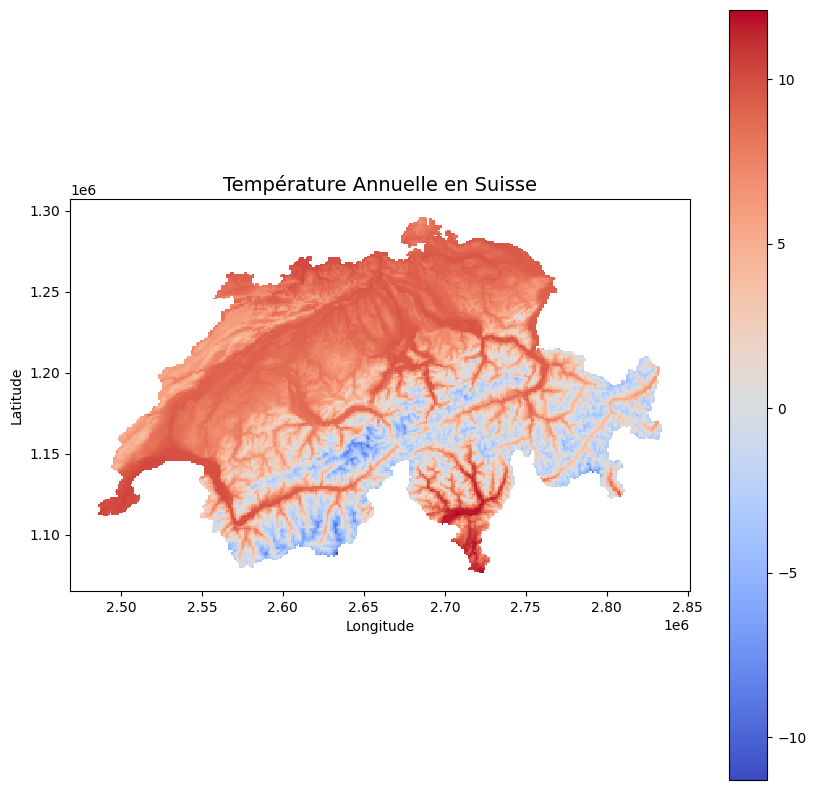

In [115]:
# Visualisation des données augmentées avec la température annuelle
fig, ax = plt.subplots(figsize=(10, 10))
swiss_data.plot(column='mean_annual_temp', ax=ax, legend=True,
                cmap='coolwarm')
ax.set_title('Température Annuelle en Suisse', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [116]:
# Sauvegarde du fichier
swiss_data.to_csv('processed_data/swiss_data_all_with_temp.csv', mode='w')